# import liberaries

In [1]:
# Model training and evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.impute import SimpleImputer
from geopy.distance import geodesic
import lightgbm as lgb
from lightgbm import LGBMClassifier
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE


# Reading the data 

In [86]:
df= pd.read_csv('../output/encoded_features.csv')
df.head()

C:\Users\Ammar\AppData\Local\Temp/ipykernel_10348/1738089754.py:1: DtypeWarning: Columns (5,6,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df= pd.read_csv('../output/encoded_features.csv')


,MONTH,DAY,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_TIME,Flight_Status,CANCELLATION_REASON,...,SEASON,IS_WEEKEND,ORIGIN_CLUSTER,DEST_CLUSTER,ORIGIN_IMPORTANCE,DEST_IMPORTANCE,DISTANCE_KM,SAME_STATE,airline_cancellation_rate,airline_flight_count
0,1,1,MQ,3303,N678MQ,DFW,GJT,133.0,0,N,...,1,0,13,64,large,small,1243.487686,0,0.062980,26564
1,1,1,NK,295,N521NK,ORD,IAH,167.0,0,N,...,1,0,5,84,large,large,1489.248234,0,0.020788,20444
2,1,1,OO,2610,N866AS,LAX,FAT,55.0,0,N,...,1,0,95,65,large,medium,336.166963,1,0.028170,50017
3,1,1,OO,5343,N584SW,LAX,SBP,59.0,0,N,...,1,0,95,65,large,small,250.265898,1,0.028170,50017
4,1,1,OO,4443,N455SW,CVG,MKE,83.0,0,N,...,1,0,53,50,medium,medium,511.514623,0,0.028170,50017


In [87]:
df.columns

Index(['MONTH', 'DAY', 'AIRLINE', 'FLIGHT_NUMBER', 'TAIL_NUMBER',
       'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'SCHEDULED_TIME',
       'Flight_Status', 'CANCELLATION_REASON', 'AIR_SYSTEM_DELAY',
       'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY',
       'WEATHER_DELAY', 'DISTANCE', 'ORIGIN_AIRPORT_CODE',
       'DESTINATION_AIRPORT_CODE', 'ORIGIN_AIRPORT_NORMALIZED',
       'DESTINATION_AIRPORT_NORMALIZED', 'IATA_CODE_y', 'ORIGIN_CITY',
       'ORIGIN_STATE', 'ORIGIN_LAT', 'ORIGIN_LON', 'IATA_CODE',
       'DESTINATION_CITY', 'DESTINATION_STATE', 'DEST_LAT', 'DEST_LON', 'YEAR',
       'DAY_OF_WEEK', 'SEASON', 'IS_WEEKEND', 'ORIGIN_CLUSTER', 'DEST_CLUSTER',
       'ORIGIN_IMPORTANCE', 'DEST_IMPORTANCE', 'DISTANCE_KM', 'SAME_STATE',
       'airline_cancellation_rate', 'airline_flight_count'],
      dtype='object')

In [88]:
def select_and_encode_features(df):
    features = [
        'MONTH', 'DAY', 'DAY_OF_WEEK', 'SEASON', 'IS_WEEKEND',
        'SCHEDULED_TIME', 'DISTANCE', 'DISTANCE_KM',
        'AIRLINE', 'airline_cancellation_rate', 'airline_flight_count',
        'ORIGIN_CLUSTER', 'DEST_CLUSTER', 
        'ORIGIN_IMPORTANCE', 'DEST_IMPORTANCE',
        'SAME_STATE', 
    ]
    df = df[features]

    # One-hot encode categoricals
    categoricals = ['AIRLINE', 'ORIGIN_IMPORTANCE', 'DEST_IMPORTANCE', 'SEASON']
    df = pd.get_dummies(df, columns=categoricals, drop_first=True)
    return df

In [70]:
df.columns

Index(['MONTH', 'DAY', 'AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
       'SCHEDULED_TIME', 'Flight_Status', 'DISTANCE',
       'ORIGIN_AIRPORT_NORMALIZED', 'DESTINATION_AIRPORT_NORMALIZED',
       'ORIGIN_CITY', 'ORIGIN_STATE', 'ORIGIN_LAT', 'ORIGIN_LON',
       'DESTINATION_CITY', 'DESTINATION_STATE', 'DEST_LAT', 'DEST_LON', 'YEAR',
       'DAY_OF_WEEK', 'SEASON', 'IS_WEEKEND', 'ORIGIN_CLUSTER', 'DEST_CLUSTER',
       'ORIGIN_IMPORTANCE', 'DEST_IMPORTANCE', 'DISTANCE_KM', 'SAME_STATE',
       'airline_cancellation_rate', 'airline_flight_count'],
      dtype='object')

In [89]:
# Split data before encoding and label separation
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['Flight_Status'], random_state=42)
# Drop labels and encode features

y_train = train_df['Flight_Status']
X_train = train_df.drop(columns=['Flight_Status'])

y_test = test_df['Flight_Status']
X_test = test_df.drop(columns=['Flight_Status'])

X_train = select_and_encode_features(X_train)
X_test = select_and_encode_features(X_test)


# model train and validate

In [90]:
def train_model(X_train, y_train, X_val=None, y_val=None):
    # Calculate class weights
    class_weights = compute_sample_weight('balanced', y_train)
    scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
    
    # Create Dataset objects
    train_data = lgb.Dataset(X_train, label=y_train, weight=class_weights)
    
    # Prepare validation data if provided
    valid_sets = [train_data]  # Always include training data for monitoring
    valid_names = ['train']
    if X_val is not None and y_val is not None:
        valid_data = lgb.Dataset(X_val, label=y_val, reference=train_data)
        valid_sets.append(valid_data)
        valid_names.append('valid')
    
    params = {
        'objective': 'binary',
        'metric': ['auc', 'average_precision'],
        'boosting_type': 'gbdt',
        'learning_rate': 0.05,
        'num_leaves': 31,
        'max_depth': -1,
        'min_child_samples': 20,
        'feature_fraction': 0.9,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': -1,
        'scale_pos_weight':scale_pos_weight,
        'random_state': 42
    }

    # Callbacks setup
    callbacks = [
        lgb.log_evaluation(50),  # Replaces verbose_eval
        lgb.early_stopping(stopping_rounds=50)
    ]
    
    model = lgb.train(
        params,
        train_data,
        num_boost_round=1000,
        valid_sets=valid_sets,
        valid_names=valid_names,
        callbacks=callbacks
    )
    
    return model

def evaluate_model(model, X, y):
    y_pred = model.predict(X)
    y_pred_binary = (y_pred >= 0.5).astype(int)
    print("Classification Report:")
    print(classification_report(y, y_pred_binary))
    print("\nConfusion Matrix:")
    print(confusion_matrix(y, y_pred_binary))
    print(f"\nROC AUC: {roc_auc_score(y, y_pred):.4f}")
    print(f"PR AUC: {average_precision_score(y, y_pred):.4f}")
    plt.figure(figsize=(10, 8))
    lgb.plot_importance(model, max_num_features=20)
    plt.title('Feature Importance')
    plt.show()

In [92]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from collections import Counter


X_train_under = X_train.copy()
y_train_under = y_train.copy()

undersampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = undersampler.fit_resample(X_train_under, y_train_under)

In [71]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("before SMOTE:\n", y_train.value_counts())
print("after SMOTE :\n", pd.Series(y_train_res).value_counts())

before SMOTE:
 0.0    419708
1.0      8522
Name: Flight_Status, dtype: int64
after SMOTE :
 0.0    419708
1.0    419708
Name: Flight_Status, dtype: int64


In [93]:
model = train_model(X_resampled, y_resampled, X_test, y_test)


Training until validation scores don't improve for 50 rounds
[50]	train's auc: 0.851887	train's average_precision: 0.848099	valid's auc: 0.837071	valid's average_precision: 0.156888
[100]	train's auc: 0.87758	train's average_precision: 0.874536	valid's auc: 0.858816	valid's average_precision: 0.196267
[150]	train's auc: 0.890274	train's average_precision: 0.886536	valid's auc: 0.866737	valid's average_precision: 0.212695
[200]	train's auc: 0.900194	train's average_precision: 0.895983	valid's auc: 0.871566	valid's average_precision: 0.229807
[250]	train's auc: 0.90944	train's average_precision: 0.905125	valid's auc: 0.877144	valid's average_precision: 0.24782
[300]	train's auc: 0.916954	train's average_precision: 0.912343	valid's auc: 0.880899	valid's average_precision: 0.260475
[350]	train's auc: 0.922783	train's average_precision: 0.917574	valid's auc: 0.883096	valid's average_precision: 0.26711
[400]	train's auc: 0.928527	train's average_precision: 0.92269	valid's auc: 0.884694	valid

# Train Evaluation


Train Evaluation:
Classification Report:
              precision    recall  f1-score   support

         0.0       0.74      0.87      0.80    419708
         1.0       0.85      0.69      0.76    419708

    accuracy                           0.78    839416
   macro avg       0.79      0.78      0.78    839416
weighted avg       0.79      0.78      0.78    839416


Confusion Matrix:
[[367218  52490]
 [131220 288488]]

ROC AUC: 0.8835
PR AUC: 0.8721


<Figure size 1000x800 with 0 Axes>

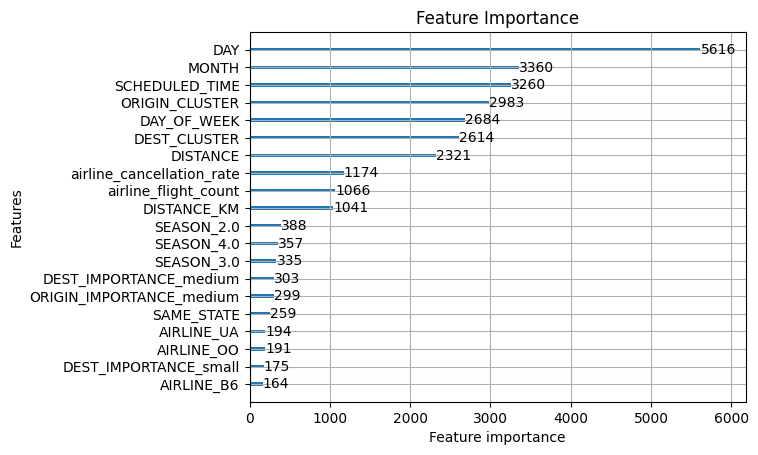

In [84]:
print("\nTrain Evaluation:")
evaluate_model(model, X_train_res, y_train_res)



# Test Evaluation


Test Evaluation:
Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.87      0.93    104928
         1.0       0.11      0.76      0.19      2130

    accuracy                           0.87    107058
   macro avg       0.55      0.82      0.56    107058
weighted avg       0.98      0.87      0.91    107058


Confusion Matrix:
[[91409 13519]
 [  508  1622]]

ROC AUC: 0.9041
PR AUC: 0.3518


<Figure size 1000x800 with 0 Axes>

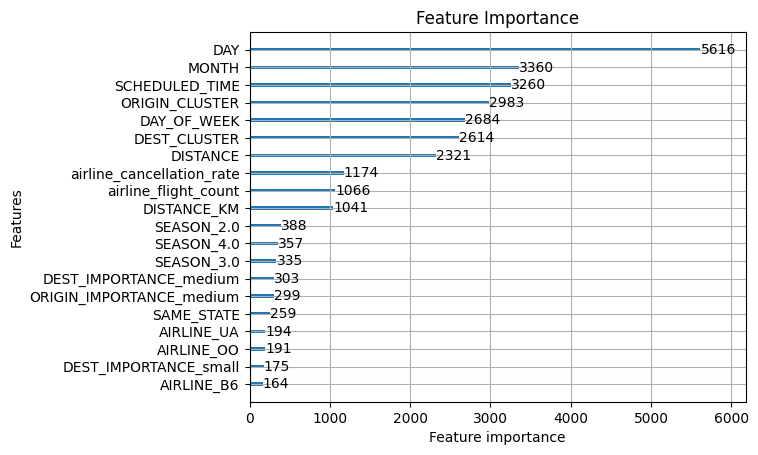

In [85]:
print("\nTest Evaluation:")
evaluate_model(model, X_test, y_test)

Text(0.5, 1.0, 'Calibration Curve')

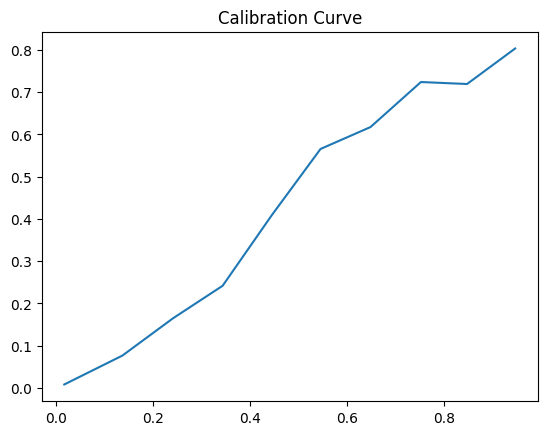

In [64]:
# Adjust for operational needs
from sklearn.calibration import calibration_curve
prob_true, prob_pred = calibration_curve(y_test, model.predict(X_test), n_bins=10)
plt.plot(prob_pred, prob_true)
plt.title("Calibration Curve")

# save the model

In [77]:
model.save_model('../output/flight_cancellation_model.txt')

# New Model 

In [3]:
# Model training and evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.impute import SimpleImputer
from geopy.distance import geodesic
import lightgbm as lgb
from lightgbm import LGBMClassifier
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE

In [4]:
df= pd.read_csv('../output/flights_preprocessed.csv')

In [5]:
df.head()

,MONTH,DAY,DAY_OF_WEEK,IS_WEEKEND,SCHEDULED_TIME,DISTANCE_KM,airline_cancellation_rate,airline_flight_count,ORIGIN_CLUSTER,DEST_CLUSTER,...,AIRLINE_VX,AIRLINE_WN,ORIGIN_IMPORTANCE_medium,ORIGIN_IMPORTANCE_small,DEST_IMPORTANCE_medium,DEST_IMPORTANCE_small,SEASON_2,SEASON_3,SEASON_4,Flight_Status
0,1,1,2,0,133.0,1243.487686,0.062980,26564,13,64,...,0,0,0,0,0,1,0,0,0,0
1,1,1,2,0,167.0,1489.248234,0.020788,20444,5,84,...,0,0,0,0,0,0,0,0,0,0
2,1,1,2,0,55.0,336.166963,0.028170,50017,95,65,...,0,0,0,0,1,0,0,0,0,0
3,1,1,2,0,59.0,250.265898,0.028170,50017,95,65,...,0,0,0,0,0,1,0,0,0,0
4,1,1,2,0,83.0,511.514623,0.028170,50017,53,50,...,0,0,1,0,1,0,0,0,0,0


In [6]:
df.columns

Index(['MONTH', 'DAY', 'DAY_OF_WEEK', 'IS_WEEKEND', 'SCHEDULED_TIME',
       'DISTANCE_KM', 'airline_cancellation_rate', 'airline_flight_count',
       'ORIGIN_CLUSTER', 'DEST_CLUSTER', 'SAME_STATE', 'AIRLINE_AS',
       'AIRLINE_B6', 'AIRLINE_DL', 'AIRLINE_EV', 'AIRLINE_F9', 'AIRLINE_HA',
       'AIRLINE_MQ', 'AIRLINE_NK', 'AIRLINE_OO', 'AIRLINE_UA', 'AIRLINE_US',
       'AIRLINE_VX', 'AIRLINE_WN', 'ORIGIN_IMPORTANCE_medium',
       'ORIGIN_IMPORTANCE_small', 'DEST_IMPORTANCE_medium',
       'DEST_IMPORTANCE_small', 'SEASON_2', 'SEASON_3', 'SEASON_4',
       'Flight_Status'],
      dtype='object')

In [7]:
df['Flight_Status'].value_counts(normalize=True)

0    0.981112
1    0.018888
Name: Flight_Status, dtype: float64

In [8]:
# Split data before encoding and label separation
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['Flight_Status'], random_state=42)
# Drop labels and encode features

y_train = train_df['Flight_Status']
X_train = train_df.drop(columns=['Flight_Status'])

y_test = test_df['Flight_Status']
X_test = test_df.drop(columns=['Flight_Status'])


In [9]:
def train_model(X_train, y_train, X_val=None, y_val=None):
    # Calculate class weights
    class_weights = compute_sample_weight('balanced', y_train)
    scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
    
    # Create Dataset objects
    train_data = lgb.Dataset(X_train, label=y_train, weight=class_weights)
    
    # Prepare validation data if provided
    valid_sets = [train_data]  # Always include training data for monitoring
    valid_names = ['train']
    if X_val is not None and y_val is not None:
        valid_data = lgb.Dataset(X_val, label=y_val, reference=train_data)
        valid_sets.append(valid_data)
        valid_names.append('valid')
    
    params = {
        'objective': 'binary',
        'metric': ['auc', 'average_precision'],
        'boosting_type': 'gbdt',
        'learning_rate': 0.05,
        'num_leaves': 31,
        'max_depth': -1,
        'min_child_samples': 20,
        'feature_fraction': 0.9,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': -1,
        'scale_pos_weight':scale_pos_weight,
        'random_state': 42
    }

    # Callbacks setup
    callbacks = [
        lgb.log_evaluation(50),  # Replaces verbose_eval
        lgb.early_stopping(stopping_rounds=50)
    ]
    
    model = lgb.train(
        params,
        train_data,
        num_boost_round=1000,
        valid_sets=valid_sets,
        valid_names=valid_names,
        callbacks=callbacks
    )
    
    return model

def evaluate_model(model, X, y):
    y_pred = model.predict(X)
    y_pred_binary = (y_pred >= 0.5).astype(int)
    print("Classification Report:")
    print(classification_report(y, y_pred_binary))
    print("\nConfusion Matrix:")
    print(confusion_matrix(y, y_pred_binary))
    print(f"\nROC AUC: {roc_auc_score(y, y_pred):.4f}")
    print(f"PR AUC: {average_precision_score(y, y_pred):.4f}")
    plt.figure(figsize=(10, 8))
    lgb.plot_importance(model, max_num_features=20)
    plt.title('Feature Importance')
    plt.show()

In [10]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("before SMOTE:\n", y_train.value_counts())
print("after SMOTE :\n", pd.Series(y_train_res).value_counts())

before SMOTE:
 0    456606
1      8790
Name: Flight_Status, dtype: int64
after SMOTE :
 0    456606
1    456606
Name: Flight_Status, dtype: int64


In [11]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from collections import Counter


X_train_under = X_train.copy()
y_train_under = y_train.copy()

oversampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(X_train_under, y_train_under)

In [12]:
model = train_model(X_resampled, y_resampled, X_test, y_test)

Training until validation scores don't improve for 50 rounds
[50]	train's auc: 0.852784	train's average_precision: 0.849663	valid's auc: 0.838956	valid's average_precision: 0.160389
[100]	train's auc: 0.877212	train's average_precision: 0.875062	valid's auc: 0.860118	valid's average_precision: 0.202189
[150]	train's auc: 0.890673	train's average_precision: 0.887464	valid's auc: 0.868497	valid's average_precision: 0.220677
[200]	train's auc: 0.900665	train's average_precision: 0.896595	valid's auc: 0.873768	valid's average_precision: 0.23555
[250]	train's auc: 0.909358	train's average_precision: 0.90497	valid's auc: 0.878492	valid's average_precision: 0.249368
[300]	train's auc: 0.916669	train's average_precision: 0.911786	valid's auc: 0.881657	valid's average_precision: 0.262172
[350]	train's auc: 0.922129	train's average_precision: 0.916717	valid's auc: 0.88288	valid's average_precision: 0.267992
[400]	train's auc: 0.927664	train's average_precision: 0.921996	valid's auc: 0.885121	val


Train Evaluation:
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.88      0.80    456606
           1       0.85      0.69      0.76    456606

    accuracy                           0.78    913212
   macro avg       0.79      0.78      0.78    913212
weighted avg       0.79      0.78      0.78    913212


Confusion Matrix:
[[399569  57037]
 [142291 314315]]

ROC AUC: 0.8834
PR AUC: 0.8732


<Figure size 1000x800 with 0 Axes>

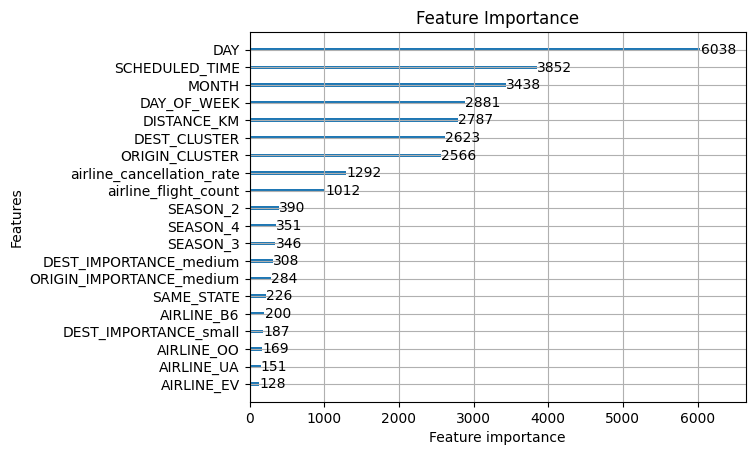

In [13]:
print("\nTrain Evaluation:")
evaluate_model(model, X_train_res, y_train_res)


Test Evaluation:
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.87      0.93    114152
           1       0.10      0.75      0.18      2198

    accuracy                           0.87    116350
   macro avg       0.55      0.81      0.55    116350
weighted avg       0.98      0.87      0.91    116350


Confusion Matrix:
[[99407 14745]
 [  543  1655]]

ROC AUC: 0.8963
PR AUC: 0.3229


<Figure size 1000x800 with 0 Axes>

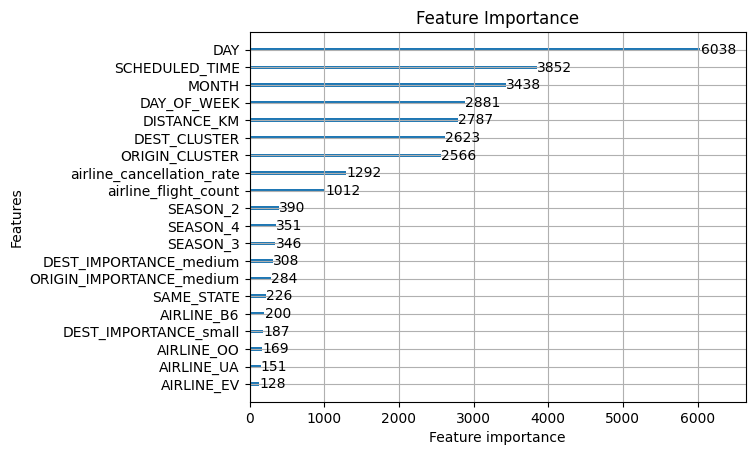

In [14]:
print("\nTest Evaluation:")
evaluate_model(model, X_test, y_test)